# 1. Setup and Get Data

## 1.1 Install Dependencies

In [ ]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

## 1.2 Collect Images using OpenCV

In [1]:
import os
import time # time library provides various functions for working with time-related operations
import uuid # uuid library creates uniform unique identifier, helps with naming the images
import cv2 # openCV library for live demo such as using webcam

In [2]:
IMAGES_PATH = os.path.join('data','images') # path with a folder data includes a folder images
number_images = 30

In [ ]:
# connect the webcam device
cap = cv2.VideoCapture(0)

# collect the images
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read() # capture the frame and return
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg') # name of image
    cv2.imwrite(imgname, frame) # write down the image
    cv2.imshow('frame', frame)  # show the image
    time.sleep(0.5) # give 0.5 time space to move around for next image

    # break out of webcam using after capturing the number of images we need
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## 1.3 Annotate Images with LabelMe

In [ ]:
# the LabelMe window will pop up, we can also type it in terminal
# remember to set the output directory to "labels" folder and set it to auto save
!labelme

# 2. Review Dataset and Build Image Loading Function

## 2.1 Import TensorFlow and Dependencities

In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

## 2.2 Limit GPU Memory Growth

In [5]:
# avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

## 2.3 Load Data into TensorFlow Data Pipeline

In [7]:
from google.colab import drive

# Mount Google Drive, allow colab to access the data in google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# look for all the images
images = tf.data.Dataset.list_files('/content/drive/MyDrive/Study/FaceDetectionProject/data/images/*.jpg')

In [9]:
# check if we successfully pick up images
images.as_numpy_iterator().next()

b'/content/drive/MyDrive/Study/FaceDetectionProject/data/images/fb462a92-21a4-11ee-94e0-52b59664a7a3.jpg'

In [10]:
# pass the image path in the function
def load_image(x):
    byte_img = tf.io.read_file(x)     # encode the image into bytes
    img = tf.io.decode_jpeg(byte_img) # decode the image back from bytes
    return img

In [11]:
# use map() to apply the load_image() function to all the images
images = images.map(load_image)

In [12]:
# display the image we decode back
images.as_numpy_iterator().next()

array([[[151, 143, 122],
        [149, 141, 120],
        [156, 150, 128],
        ...,
        [217, 217, 205],
        [214, 214, 202],
        [211, 211, 199]],

       [[148, 140, 119],
        [154, 146, 125],
        [149, 143, 121],
        ...,
        [217, 217, 205],
        [214, 214, 202],
        [211, 211, 199]],

       [[149, 141, 122],
        [149, 141, 122],
        [164, 156, 137],
        ...,
        [217, 217, 205],
        [214, 214, 202],
        [211, 211, 199]],

       ...,

       [[102,  96,  70],
        [102,  96,  70],
        [102,  96,  70],
        ...,
        [119, 113,  91],
        [118, 112,  90],
        [117, 111,  89]],

       [[101,  97,  70],
        [101,  97,  70],
        [101,  97,  68],
        ...,
        [121, 115,  93],
        [124, 116,  93],
        [126, 118,  95]],

       [[100,  96,  69],
        [ 99,  95,  68],
        [100,  96,  67],
        ...,
        [119, 113,  91],
        [127, 119,  96],
        [133, 125, 102]]

In [17]:
# all the images have been passed through TF pipeline and stored as a MapDataset in TF
type(images)

tensorflow.python.data.ops.map_op._MapDataset

## 2.4 View Raw Images with Matplotlib

In [18]:
# pick a batch of 4 images
image_generator = images.batch(4).as_numpy_iterator()

In [21]:
# run this line to get a new batch of data every time
plot_images = image_generator.next()

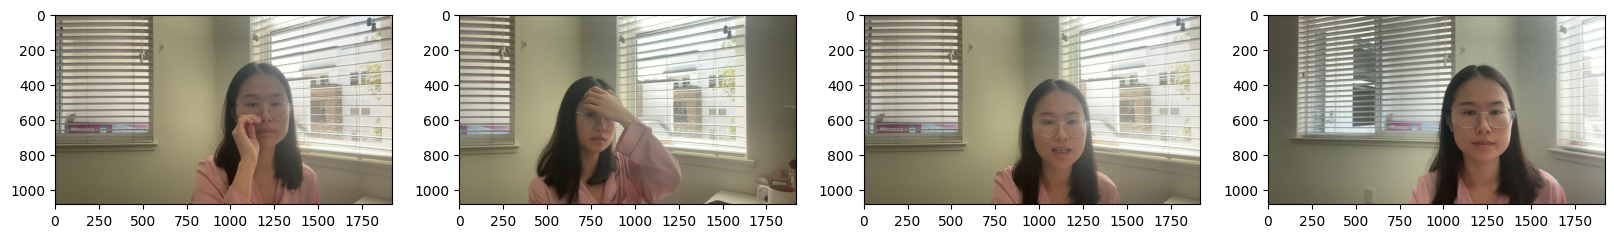

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)

# display the images
plt.show()

# 3. Partition Unaugmented Data

## 3.1 MANUALLY SPLT DATA INTO "TRAIN" "TEST" AND "VALIDATION"

create 3 folders under "data" folder : "train" "test" "val" and move data to these folders respectively

we can also use code to split it randomly

train = 90 * .7 = 63

test = 90 * .15 = 14

val = 90 * .15 = 13

## 3.2 Move the Matching Labels

In [23]:
# map the paired label json files to corresponding "labels" folder
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('/content/drive/MyDrive/Study/FaceDetectionProject/data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('/content/drive/MyDrive/Study/FaceDetectionProject/data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('/content/drive/MyDrive/Study/FaceDetectionProject/data', folder ,'labels', filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply Image Augmentation on A Test Image and Label using Albumentations

## 4.1 Setup Albumentations Transform Pipeline

In [58]:
import albumentations as alb

In [59]:
# create the augmentation pipeline
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params=alb.BboxParams(format='albumentations', # adjust the coordinates according to albumentations's format
                                                    label_fields=['class_labels']))

## 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [61]:
# randomly load a test image
img = cv2.imread(os.path.join('/content/drive/MyDrive/Study/FaceDetectionProject/data','train', 'images','01d53230-21a6-11ee-9941-52b59664a7a3.jpg'))

# display the shape of the image
img.shape

(1080, 1920, 3)

In [62]:
with open(os.path.join('/content/drive/MyDrive/Study/FaceDetectionProject/data', 'train', 'labels', '01d53230-21a6-11ee-9941-52b59664a7a3.json'), 'r') as f:
    label = json.load(f)

In [63]:
# display the whole annotation
label

{'version': '5.2.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[941.7307692307693, 284.2307692307693],
    [1378.2692307692307, 849.6153846153846]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '../images/01d53230-21a6-11ee-9941-52b59664a7a3.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAQ4B4ADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJ

In [64]:
# display the label
label['shapes'][0]['label']

'face'

In [65]:
# display the coordinate points
label['shapes'][0]['points']

[[941.7307692307693, 284.2307692307693],
 [1378.2692307692307, 849.6153846153846]]

## 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [66]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0] # x1
coords[1] = label['shapes'][0]['points'][0][1] # y1
coords[2] = label['shapes'][0]['points'][1][0] # x2
coords[3] = label['shapes'][0]['points'][1][1] # y2

# print coords
coords

[941.7307692307693, 284.2307692307693, 1378.2692307692307, 849.6153846153846]

In [67]:
# update the original coordinates to albumentations format (which is adjusted according to the size of the image)
coords = list(np.divide(coords, [1920, 1080, 1920, 1080]))

# display the coords of albumentations format
coords

[0.49048477564102566,
 0.2631766381766382,
 0.7178485576923077,
 0.7866809116809117]

## 4.4 Apply Augmentations and View Results

In [68]:
# pass image, updated coordinates, labels to augmentor and return a dict result
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [69]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [70]:
augmented

{'image': array([[[176, 195, 201],
         [177, 196, 202],
         [176, 195, 201],
         ...,
         [ 68, 100, 145],
         [ 70,  99, 145],
         [ 71, 100, 146]],
 
        [[185, 204, 210],
         [186, 205, 211],
         [187, 206, 212],
         ...,
         [ 66,  98, 143],
         [ 67,  96, 142],
         [ 69,  98, 144]],
 
        [[184, 201, 207],
         [184, 201, 207],
         [182, 199, 205],
         ...,
         [ 68, 100, 145],
         [ 69,  98, 144],
         [ 70,  99, 145]],
 
        ...,
 
        [[114, 135, 144],
         [113, 134, 143],
         [112, 133, 142],
         ...,
         [131, 171, 179],
         [130, 172, 180],
         [130, 172, 180]],
 
        [[111, 135, 143],
         [111, 135, 143],
         [110, 134, 142],
         ...,
         [131, 171, 179],
         [132, 172, 180],
         [132, 172, 180]],
 
        [[110, 134, 142],
         [110, 134, 142],
         [110, 134, 142],
         ...,
         [131, 171,

In [71]:
augmented['image'].shape # the image is cropped

(450, 450, 3)

In [72]:
augmented['bboxes'] # the coordinates of the cropped image

[(0.34162393162393173, 0.0, 1.0, 0.7150427350427349)]

In [73]:
augmented['bboxes'][0][:2] # the x_min, y_min coordinate

(0.34162393162393173, 0.0)

In [74]:
augmented['bboxes'][0][2:] # the x_max, y_max coordinate

(1.0, 0.7150427350427349)

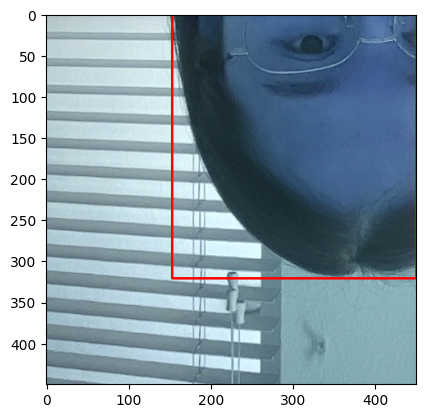

In [75]:
# draw a rectangle of the image and show the face
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)), # the x_min, y_min coordinate
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), # the x_max, y_max coordinate
              (255,0,0), # the bgr color format
              2          # the thickness of the line
              )

# plot the augmented image
plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

## 5.1 Run Augmentation Pipeline for All Images

In [ ]:
# loop through all 3 folders to read all the images
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('/content/drive/MyDrive/Study/FaceDetectionProject/data', partition, 'images')):
        img = cv2.imread(os.path.join('/content/drive/MyDrive/Study/FaceDetectionProject/data', partition, 'images', image))

        # create a default coords for image without label json file (means no face in the image)
        coords = [0,0,0.00001,0.00001]

        label_path = os.path.join('/content/drive/MyDrive/Study/FaceDetectionProject/data', partition, 'labels', f'{image.split(".")[0]}.json')

        # if image has a paired label json file, get the coordinates
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1920, 1080, 1920, 1080]))

        # for each base image, create 60 augmented images respectively. Total we have 90 * 60 * 60 images
        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

                # save the augmented images to "aug_data" folder parallel with "data" folder
                cv2.imwrite(os.path.join('/content/drive/MyDrive/Study/FaceDetectionProject/aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                # create annotation (label json file) for each augmented image
                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 # no face label 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1 # label "face" is 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0


                with open(os.path.join('/content/drive/MyDrive/Study/FaceDetectionProject/aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

## 5.2 Load Augmented Images to Tensorflow Dataset

In [76]:
# Define the partitions and directory paths
partitions = ['train', 'test', 'val']
directories = ['/content/drive/MyDrive/Study/FaceDetectionProject/aug_data/train/images/*.jpg',
               '/content/drive/MyDrive/Study/FaceDetectionProject/aug_data/test/images/*.jpg',
               '/content/drive/MyDrive/Study/FaceDetectionProject/aug_data/val/images/*.jpg']

# Create an empty list to store the combined datasets
combined_datasets = []

# Iterate over the datasets and directories
for partition, directory in zip(partitions, directories):
    images = tf.data.Dataset.list_files(directory, shuffle = False)
    images = images.map(load_image)
    images = images.map(lambda x: tf.image.resize(x, (120, 120))) # compress the image to 120 * 120
    images = images.map(lambda x: x / 255) # pixel values in images are typically represented as integers ranging from 0 to 255, we normalize it to 0~1 so we can use sigmoid function

    # Append the processed dataset to the combined datasets list
    combined_datasets.append(images)

# Now we have a list of combined datasets for train, test, and val
# access each dataset using the corresponding index
train_images = combined_datasets[0]
test_images = combined_datasets[1]
val_images = combined_datasets[2]

In [77]:
train_images.as_numpy_iterator().next()

array([[[0.5092524 , 0.45042893, 0.36023283],
        [0.5127451 , 0.45      , 0.35980392],
        [0.5052083 , 0.44246325, 0.35226715],
        ...,
        [0.32150736, 0.2940564 , 0.22346814],
        [0.33927697, 0.30398285, 0.23731618],
        [0.3319853 , 0.29669118, 0.23002452]],

       [[0.4918505 , 0.43302697, 0.3428309 ],
        [0.4985294 , 0.4357843 , 0.34558824],
        [0.49509802, 0.43235293, 0.34215686],
        ...,
        [0.27469364, 0.23939951, 0.17371324],
        [0.27248776, 0.23719363, 0.17150736],
        [0.27046567, 0.23517157, 0.16887255]],

       [[0.49050245, 0.43167892, 0.34148285],
        [0.50539213, 0.44264707, 0.35245097],
        [0.49509802, 0.4362745 , 0.34607843],
        ...,
        [0.32671568, 0.27965686, 0.21691176],
        [0.30851716, 0.27175245, 0.20557599],
        [0.30447304, 0.26917893, 0.20251225]],

       ...,

       [[0.48186275, 0.45441177, 0.39166668],
        [0.48137254, 0.45392156, 0.39117646],
        [0.47745097, 0

# 6. Prepare Labels

## 6.1 Build Label Loading Function

In [78]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

## 6.2 Load Labels to Tensorflow Dataset

In [79]:
# Define the partitions and directory paths
partitions = ['train', 'test', 'val']
directories = ['/content/drive/MyDrive/Study/FaceDetectionProject/aug_data/train/labels/*.json',
               '/content/drive/MyDrive/Study/FaceDetectionProject/aug_data/test/labels/*.json',
               '/content/drive/MyDrive/Study/FaceDetectionProject/aug_data/val/labels/*.json']

# Create an empty list to store the combined label datasets
combined_label_datasets = []

# Iterate over the datasets and directories
for partition, directory in zip(partitions, directories):
    labels = tf.data.Dataset.list_files(directory, shuffle = False)
    labels = labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16])) # [x] is the json file path that would be passed to the load_labels() function

    # Append the processed label dataset to the combined datasets list
    combined_label_datasets.append(labels)

# with a list of combined label datasets for train, test, and val
# we can access each dataset using the corresponding index
train_labels = combined_label_datasets[0]
test_labels = combined_label_datasets[1]
val_labels = combined_label_datasets[2]

In [80]:
train_labels.as_numpy_iterator().next() # the first array is the class, the second array is the coordinates

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples

## 7.1 Check Partition Lengths

In [81]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

## 7.2 Create Final Datasets (Images/Labels)

In [82]:
# Define the dataset and label pairs
datasets = [train_images, test_images, val_images]
labels = [train_labels, test_labels, val_labels]

# Create an empty list to store the combined datasets
combined_datasets = []

# Iterate over the datasets and labels
for dataset, label in zip(datasets, labels):
    combined_dataset = tf.data.Dataset.zip((dataset, label))
    if dataset == train_images:
      combined_dataset = combined_dataset.shuffle(5000)  # shuffle buffer should be greater than dataset size
    else: # if dataset is test and val
      combined_dataset = combined_dataset.shuffle(1300)

    combined_dataset = combined_dataset.batch(8)
    combined_dataset = combined_dataset.prefetch(4) # creates a buffer and starts loading and preprocessing the next batch of data while the current batch is being consumed by the model

    # Append the combined dataset to the list
    combined_datasets.append(combined_dataset)

train = combined_datasets[0]
test = combined_datasets[1]
val = combined_datasets[2]

In [83]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.    , 0.    , 0.5005, 0.281 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.0395, 0.9062, 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.6636, 0.55  , 1.    ],
        [0.    , 0.    , 0.7505, 0.528 ]], dtype=float16))

## 7.3 View Images and Annotations

In [84]:
# loop through all different batches in the "train" dataset with combines images and labels
data_samples = train.as_numpy_iterator()

In [85]:
# grab the next batch
res = data_samples.next()

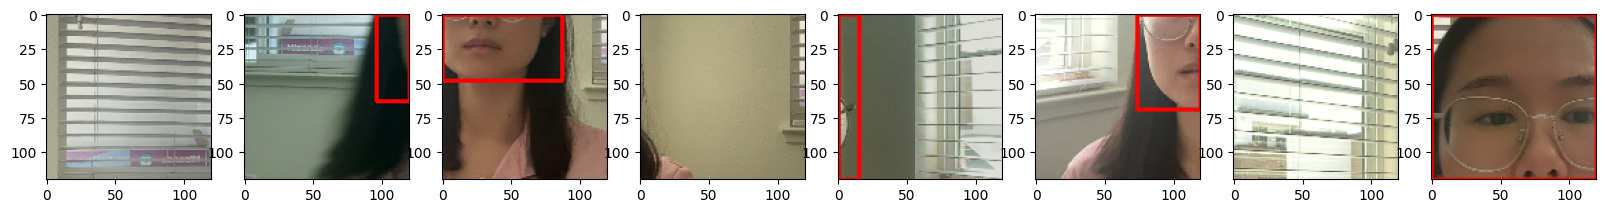

In [86]:
# plot the images in batch
fig, ax = plt.subplots(ncols = 8, figsize = (20, 20))

for idx in range(8):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0),
                  2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

Keras sequential API only allows 1 input, 1 output and 1 loss function.

So here we use Keras Functional API, which allows us to add 2 layers (the classification layer and the regression layer) on top of the VGG16 base model, and define our own loss function by combining the binary cross entropy loss and the location loss.

## 8.1 Import Layers and Base Network

In [87]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.2 Download VGG16

In [88]:
vgg = VGG16(include_top = False) # include top = False means that we dont need the final layer of VGG16 (a classification layer), but later add our own classification & regression layers

In [89]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 8.3 Build Instance of Network

In [90]:
def build_model():
    # specify the input layer
    input_layer = Input(shape = (120, 120, 3))

    # create the vgg16 and pass the input_layer to this base model
    vgg = VGG16(include_top = False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg) # condense the result of vgg layers with GlobalMaxPooling2D()
    class1 = Dense(2048, activation='relu')(f1) # pass the vgg result to a dense layer get 2048 outputs (2048 neurons in this layer, self-defined)
    class2 = Dense(1, activation='sigmoid')(class1) # class 2 is a dense layer generate 1 output, a sigmoid one from 0~1

    # Regression Model (create coordinates for bounding box)
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1) # regress 2 is a dense layer generate 4 outputs, sigmoid ones from 0~1

    # there are 2 outputs: a classification output indicate face or not; a regression output gives the coordinates
    facetracker = Model(inputs = input_layer, outputs = [class2, regress2])

    return facetracker

## 8.4 Test out Neural Network

In [91]:
# build our facetracker model
facetracker = build_model()

In [92]:
# show the layers of the model
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [93]:
# take a piece of training sample
# X - image; y - label
X, y = train.as_numpy_iterator().next()

In [94]:
# a batch of 8
X.shape

(8, 120, 120, 3)

In [95]:
y

(array([[1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.    , 0.52  , 1.    , 1.    ],
        [0.    , 0.    , 0.8306, 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.1247, 0.8403],
        [0.    , 0.2434, 0.7153, 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.5605, 0.504 ]], dtype=float16))

In [96]:
# predict output class and coordinates (haven't train the model)
classes, coords = facetracker.predict(X)
classes, coords

1/1 [==============================] - 2s 2s/step


(array([[0.3580608 ],
        [0.3734493 ],
        [0.45201054],
        [0.4114185 ],
        [0.31449842],
        [0.32980835],
        [0.41605344],
        [0.33947572]], dtype=float32),
 array([[0.43392342, 0.62922937, 0.4146081 , 0.51595795],
        [0.3808584 , 0.5973436 , 0.41203305, 0.58842987],
        [0.49368048, 0.5765931 , 0.38847926, 0.5865356 ],
        [0.40549156, 0.60242814, 0.4085992 , 0.5473727 ],
        [0.36024645, 0.6593177 , 0.40007207, 0.564168  ],
        [0.42265305, 0.69438905, 0.41620615, 0.5172086 ],
        [0.4271942 , 0.59776044, 0.41149542, 0.5258905 ],
        [0.4106969 , 0.6995196 , 0.43718106, 0.52961904]], dtype=float32))

# 9. Define Losses and Optimizers

## 9.1 Define Optimizer and LR

In [97]:
# the whole epoch has XX batches
batches_per_epoch = len(train)

# learning rate decay: reduce the learning rate during training to achieve better convergence or prevent overshooting the optimal solution
lr_decay = (1./0.75 -1)/ batches_per_epoch

The value 0.75 indicates the decay factor itself, determining the rate of decay.

Subtracting 1 is done to adjust the decay factor to a relative value compared to the initial learning rate.

Divided by batches_per_epoch is performed to normalize the decay factor across the entire training process. By dividing by batches_per_epoch, the decay factor is scaled down to adjust for the number of iterations per epoch. It ensures that the learning rate decay is consistent across different dataset sizes and batch configurations.

In [98]:
# create the optimizer
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay) # 0.0001 is a common choice

A smaller learning rate generally leads to slower but more precise convergence, while a larger learning rate can result in faster convergence but may risk overshooting the optimal solution.

## 9.2 Create Localization Loss and Classification Loss

In [99]:
# define the localization loss
def localization_loss(y_true, yhat):
    # calculate coordination loss: (x - x^)^2 + (y - y^)^2
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2])) # get x and y at the same time

    # calculate the actural height and width
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    # get the predicted height and width
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    # calculate coordination loss: (w - w^)^2 + (height - height^)^2
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [100]:
# get classification loss and localization loss respectively
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test Out Loss Metrics

In [101]:
classloss(y[0], classes).numpy()

0.87848514

In [102]:
localization_loss(y[1], coords).numpy()  # y[0] is label, y[1] is coordinates prediction

10.032345

In [103]:
regressloss(y[1], coords).numpy() # we can see localization loss is actually regression loss as we designed

10.032345

# 10. Train Neural Network

## 10.1 Create Custom Model Class (Training Pipeline)

In [104]:
class FaceTracker(Model): # the Model is the one imported from Keras

    # init method: to pass through the initial parameters: A pre-build network (it is actually the facetracker model we built based on VGG16)
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    # compile method: to pass through the loss function and the optimizer
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    # train step method: pass in a batch of data and train it
    def train_step(self, batch, **kwargs):

        # unpack X and y
        X, y = batch

        with tf.GradientTape() as tape:
            # pass the training data "X" to the "model" (former eyetracker, actually facetracker)
            classes, coords = self.model(X, training = True)

            # calculate classification loss with closs(), pass through y true (y[0]) and y predict (classes)
            batch_classloss = self.closs(y[0], classes)

            # calculate localization loss with lloss(), pass through y true (y[1], cast to float) and y predict (coords)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            # total loss: can try other formula
            total_loss = batch_localizationloss + 0.5 * batch_classloss

            # calculate the gradient of each layer
            grad = tape.gradient(total_loss, self.model.trainable_variables)

        # apply gradient descent - minimizing loss
        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    # test step method: pass in a batch of test data
    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training = False) # not apply training

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    # a call() function for dot operation
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [105]:
# set up the model
model = FaceTracker(facetracker)

In [106]:
# compile the model pipeline
model.compile(opt, classloss, regressloss)

## 10.2 Train Models

In [107]:
# set the log directory
logdir = 'logs'

In [108]:
# set the callback board so we can review later
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [109]:
# train the model and save the loss results to hist (here can use train.take(N) to take N number of training data, or just "train" to train on all data)
hist = model.fit(train, epochs = 5, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/5
473/473 [==============================] - 2796s 6s/step - total_loss: 0.9940 - class_loss: 0.2170 - regress_loss: 0.8855 - val_total_loss: 0.4069 - val_class_loss: 0.2417 - val_regress_loss: 0.2861
Epoch 2/5
473/473 [==============================] - 2752s 6s/step - total_loss: 0.4542 - class_loss: 0.1237 - regress_loss: 0.3923 - val_total_loss: 0.2189 - val_class_loss: 0.0810 - val_regress_loss: 0.1784
Epoch 3/5
473/473 [==============================] - 2745s 6s/step - total_loss: 0.3880 - class_loss: 0.1134 - regress_loss: 0.3313 - val_total_loss: 0.2560 - val_class_loss: 0.1093 - val_regress_loss: 0.2013
Epoch 4/5
473/473 [==============================] - 2741s 6s/step - total_loss: 0.2900 - class_loss: 0.0902 - regress_loss: 0.2449 - val_total_loss: 0.0278 - val_class_loss: 0.0274 - val_regress_loss: 0.0142
Epoch 5/5
473/473 [==============================] - 2832s 6s/step - total_loss: 0.2050 - class_loss: 0.0624 - regress_loss: 0.1739 - val_total_loss: 0.0267 - val_c

## 10.3 Plot Performance

In [110]:
# get the history of the model training (loss variables of each epoch)
hist.history

{'total_loss': [0.09402520954608917,
  0.3220721185207367,
  0.06447896361351013,
  0.012856999412178993,
  0.031103890389204025],
 'class_loss': [0.022935565561056137,
  0.19262531399726868,
  0.0045227184891700745,
  0.0194561630487442,
  0.007312625180929899],
 'regress_loss': [0.08255742490291595,
  0.22575946152210236,
  0.062217604368925095,
  0.003128917422145605,
  0.027447577565908432],
 'val_total_loss': [0.40689802169799805,
  0.2188844084739685,
  0.25597652792930603,
  0.02784803882241249,
  0.026731427758932114],
 'val_class_loss': [0.24168023467063904,
  0.08098025619983673,
  0.10933475196361542,
  0.02738753706216812,
  0.0043585109524428844],
 'val_regress_loss': [0.28605788946151733,
  0.17839428782463074,
  0.20130914449691772,
  0.01415427029132843,
  0.024552172049880028]}

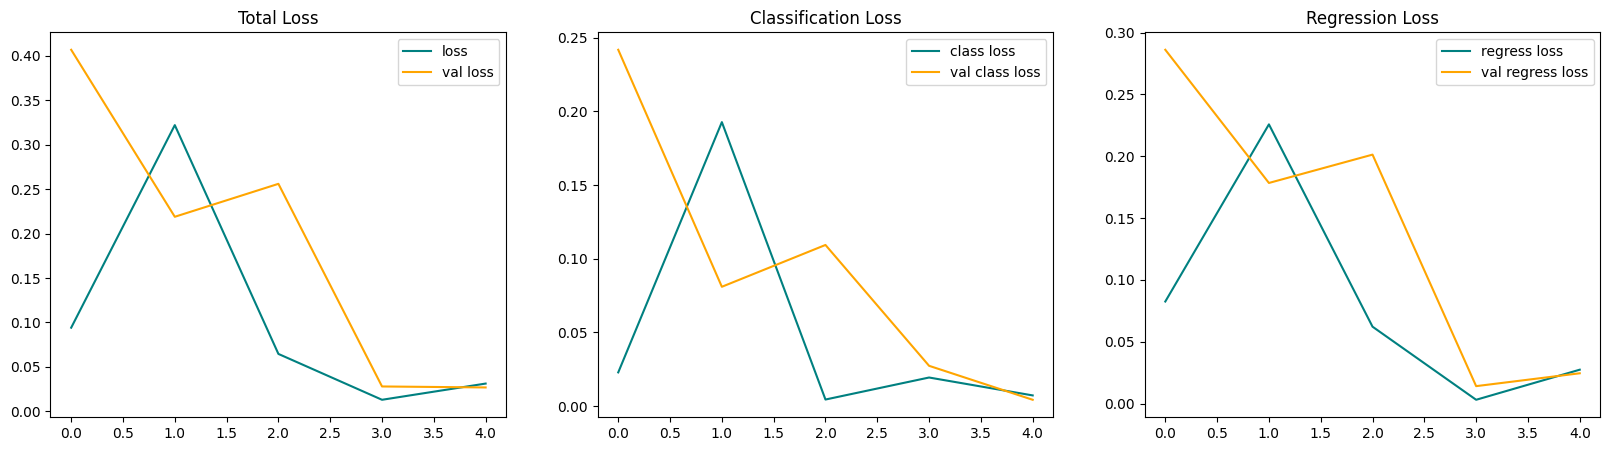

In [111]:
# plot the performance
fig, ax = plt.subplots(ncols = 3, figsize = (20, 5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Total Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

## 11.1 Make Predictions on Test Set

In [112]:
# read all the test data
test_data = test.as_numpy_iterator()

In [113]:
# iterate next batch
test_sample = test_data.next()

In [114]:
# predict the test data with trained facetracker model
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 2s 2s/step


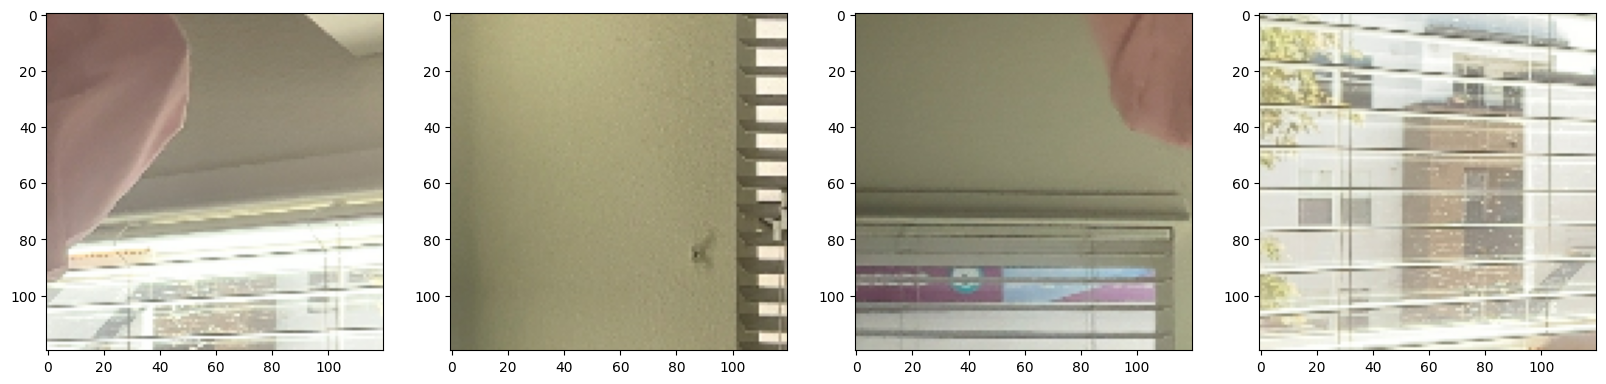

In [115]:
# plot the result
fig, ax = plt.subplots(ncols = 4, figsize = (20 ,20))

for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    # only plot the image with probability > 0.9
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                      (255,0,0),
                      2)

    ax[idx].imshow(sample_image)

## 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# save the model as a h5 file
model.save('/content/drive/MyDrive/Study/FaceDetectionProject/facetracker.h5')

In [ ]:
# reload the model back
facetracker = load_model('facetracker.h5')

## 11.3 Real Time Detection

In [ ]:
# use openCV to use webcam for real time detection
cap = cv2.VideoCapture(0)

while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500, :]

    # convert bgr (in OpenCV) to RGB (for tensorflow)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))

    # predict the result with the facetracker model
    yhat = facetracker.predict(np.expand_dims(resized/255, 0))

    # get the coordinates
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Control the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                      (255,0,0),
                      2)

        # Control the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [80,0])),
                      (255,0,0),
                      -1)

        # Control the text rendered
        cv2.putText(frame,
                    'face',
                    tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (255,255,255),
                    2,
                    cv2.LINE_AA)

    # show the pop up webcam frame named "FaceTracker"
    cv2.imshow('FaceTracker', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

The End. Have fun!